# Проект "Моделирование оттока клиентов сети фитнес-центров"

## Содержание

##### Часть 1. Введение
* [1.1 Цель проекта](#section_1.1)
* [1.2 Описание данных](#section_1.2)

##### Часть 2. Исследовательский анализ данных
* [2.1 Загрузка библиотек и ознакомление с данными](#section_2.1)
* [2.2 Сравнение признаков для выборок клиентов, попавших в отток и не попавших в отток](#section_2.2)

##### Часть 3. Модели прогнозирования оттока клиентов
* [3.1 Подготовка данных и функций](#section_3.1)
* [3.2 Логистическая регрессия](#section_3.2)
* [3.3 Случайный лес](#section_3.3)
* [3.4 Сравнение метрик моделей](#section_3.2)

##### Часть 4. Кластеризация клиентов
* [4.1 Определение количества кластеров на основании дендрограммы](#section_4.1)
* [4.2 Кластеризация и анализ признаков каждого кластера](#section_4.2)

##### Часть 5. Выводы и рекомендации
* [5.1 Выводы](#section_5.1)
* [5.2 Рекомендации](#section_5.2)

## 1. Введение

<a id='section_1.1'></a>
### 1.1 Цель проекта

Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал и по приезду продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.

Задача проекта — провести анализ данных о клиентах сети и передать в отдел маркетинга для подготовки рекомендаций по их удержанию.

В рамках проекта планируется:
- подготовить модели, прогнозирующие вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами: выделить целевые группы клиентов; предложить меры по снижению оттока; определить другие особенности взаимодействия с клиентами.

<a id='section_1.2'></a>
### 1.2 Описание данных

Набор данных содержит следующую информацию: 

1. факт оттока в текущем месяце;
2. данные клиента за предыдущий до проверки факта оттока месяц:
    - пол;
    - проживание или работа в районе, где находится фитнес-центр;
    - является ли клиент сотрудником компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
    - факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
    - наличие контактного телефона;
    - возраст;
    - время с момента первого обращения в фитнес-центр (в месяцах).
3. информацию на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
    - длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
    - срок до окончания текущего действующего абонемента (в месяцах);
    - факт посещения групповых занятий;
    - средняя частота посещений в неделю за все время с начала действия абонемента;
    - средняя частота посещений в неделю за предыдущий месяц;
    - суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

## 2. Исследовательский анализ данных
В этой части мы планируем изучить датасет: проверить на наличие пропусков в данных, изучить средние значения и стандартные отклонения. Кроме того, мы более детально рассмотрим средние значения и распределения признаков в двух группах — тех, кто ушел в отток и тех, кто остался. А также проверим наличие корреляции между признаками.

<a id='section_2.1'></a>
### 2.1 Загрузка библиотек и ознакомление с данными

In [1]:
# загрузим необходимые библиотеки и модули
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

import warnings
warnings.filterwarnings('ignore')

In [2]:
# прочитаем данные из csv-файла 
raw_data = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
# посмотрим первые строки
raw_data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
# посмотрим информацию о данных 
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [5]:
raw_data.duplicated().sum()

0

Видим, что данные полные и чистые: не содержат пропусков и дубликатов. 

In [6]:
# переведем названия столбцов в нижний регистр
raw_data.columns = raw_data.columns.str.lower()

In [7]:
# посмотрим основные статистические характеристики данных
raw_data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


На основании полученных данных можем сделать вывод, что среднестатистический клиент нашей сети фитнес-центров, обладает следующими признаками:

- возраст - 29 лет, 
- работает или проживает вблизи от фитнес-центра,
- посещает фитнес-центр примерно 3,7 месяца и имеет абонемент сроком на 5 месяцев,
- посещает примерно 2 групповые тренировки в месяц,
- за время посещения фитнес-центра потратил на дополнительные услуги 147 условных единиц.

Так как единицы, в которых измеряются различные признаки, иногда могут отличаться на порядок, то перед обучением моделей предварительно стандартизируем данные, чтобы не получить перекос в весе того или иного признака.

<a id='section_2.2'></a>
### 2.2 Сравнение признаков для выборок клиентов, попавших в отток и не попавших в отток

In [8]:
pd.set_option('max_colwidth', -1)
# сравним средние показатели клиентов, попавших и не попавших в отток
raw_data.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


В таблице видим средние показатели для выборки клиентов, которые все еще продолжают посещать фитнес-цент (показатель churn равен 0), и клиентов, которые ушли (показатель churn равен 1).

Для большей наглядности построим графики для сравнения распределения признака.

In [9]:
# сохраним количественные и категориальные признаки в отдельные переменные 
quantative_vars = ['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 
                   'lifetime','avg_class_frequency_total', 'avg_class_frequency_current_month'
                  ]

categorial_vars = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']

In [10]:
# напишем функцию для сравнения графиков распределения количественных признаков
def compare_quantative_characteristics(df, var_list, x):
    for column in var_list:
        plt.figure(figsize = (6, 6))
        sns.boxplot(x = x, y = column, data = df)
        plt.title('Распределение признака ' + column, fontweight = 'bold', fontsize = 14)
        plt.show()

In [11]:
# напишем функцию для сравнения графиков распределения категориальных признаков
def compare_categorial_characteristics(df, var_list, x):
    for column in var_list:
        sns.barplot(data = df, x = x, y = column)
        plt.title('Среднее значение признака ' + column, fontweight = 'bold', fontsize = 14)
        plt.show()

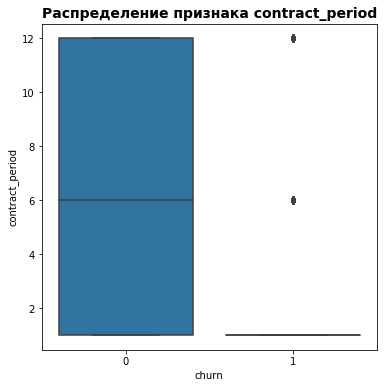

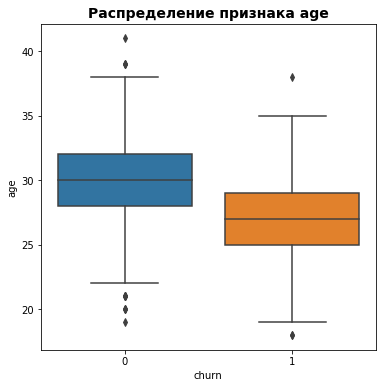

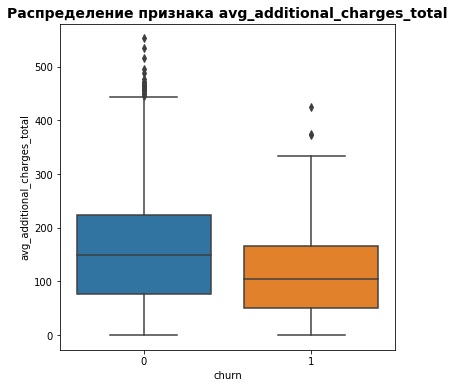

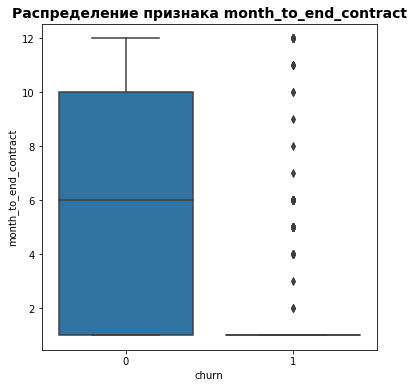

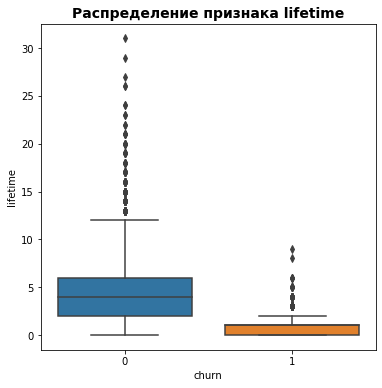

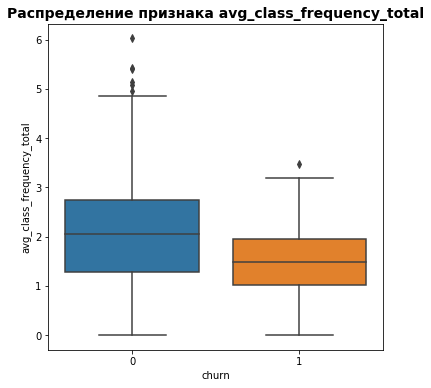

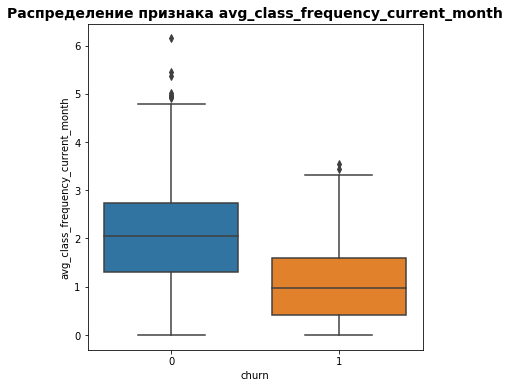

In [12]:
# сравним распределение количественных признаков клиентов, попавших в отток и не попавших в отток
compare_quantative_characteristics(raw_data, quantative_vars, 'churn')

При сравнении количественных признаков наибольшая разница между ушедшими и оставшимися клиентами видна в следующих признаках:

1) количество месяцев до истечения договора. Оно существенно больше у клииентов, продолжающих посещать фитнес-центры. Это вполне логично, так как отток клиентов, скорее всего, происходит по окончании срока действия договора.

2) срок абонемента. Аналогично, срок действия абонемента существенно больше у клиентов, которые продолжают посещать центры. Срок действия абонемента у подавляющиего большинства клиентов, попавших в отток, составляет 1 месяц. Скорее всего, это клиенты, которые сразу планируют посещать центр в течение короткого периода, либо приобретают абонемент для того, чтобы попробовать и принять решение о дальнейшем посещении. 

3) срок с момента первого обращения в центр. Этот период в несколько раз меньше у клиентов, попавших в отток.

4) средняя посещаемость групповых классов. В то время как средняя посещаемость групповых классов в течение всего срока посещения фитнес-центров у обоих категорий не сильно отличается, обращает на себя внимание более существенное отличие в посещаемости групповых классов в последний месяц - в последний месяц (месяц перед оттоком - для тех клиентов, кто прекратил посещать фитнес-центр) медиана посещений у клиентов, попавших в отток, составялет 1 посещение, в то время, как у оставшихся клиентов - 2 посещения.

В качестве дополнительных наблюдений можно отметить, что возраст, продолжающих посещать центры клиентов, немного выше (примерно на 3 года), и их дополнительные траты в центре тоже слегка больше (примерно на 45 условных единиц).

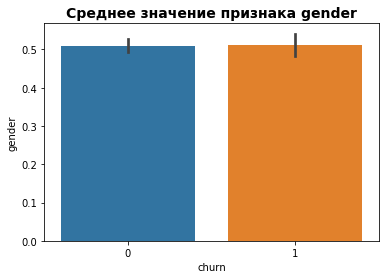

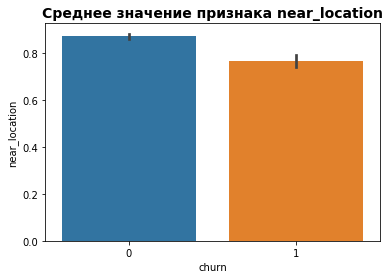

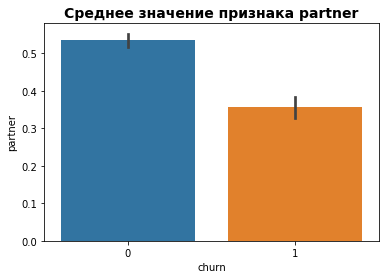

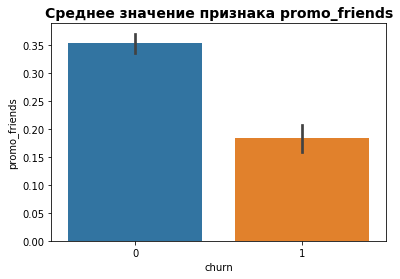

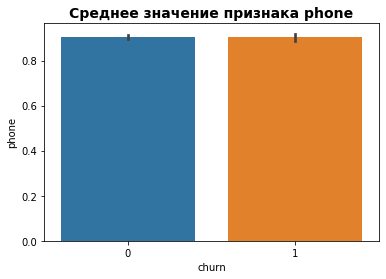

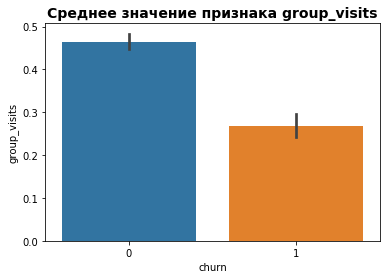

In [13]:
# сравним средние значения категориальных признаков клиентов, попавших в отток и не попавших в отток
compare_categorial_characteristics(raw_data, categorial_vars, 'churn')

При сравнении категориальных признаков можно отметить, что распределение по половому признаку примерно одинаково в обеих группах. Количество клиентов, оставивших свой номер телефона, так же одинаково.

Однако, клиенты, продолжающие посещать фитнес-центры, чаще:
- являются сотрудниками компаний партнеров (доля незначительно отличается),
- первоначально пришли в центр в рамках акции «приведи друга» (доля существенно отличается),
- проживают вблизи от фитнес-центра (доля незначительно отличается),
- посещают групповые тренировки (доля существенно отличается).

Визуализируем матрицу корреляции признаков.

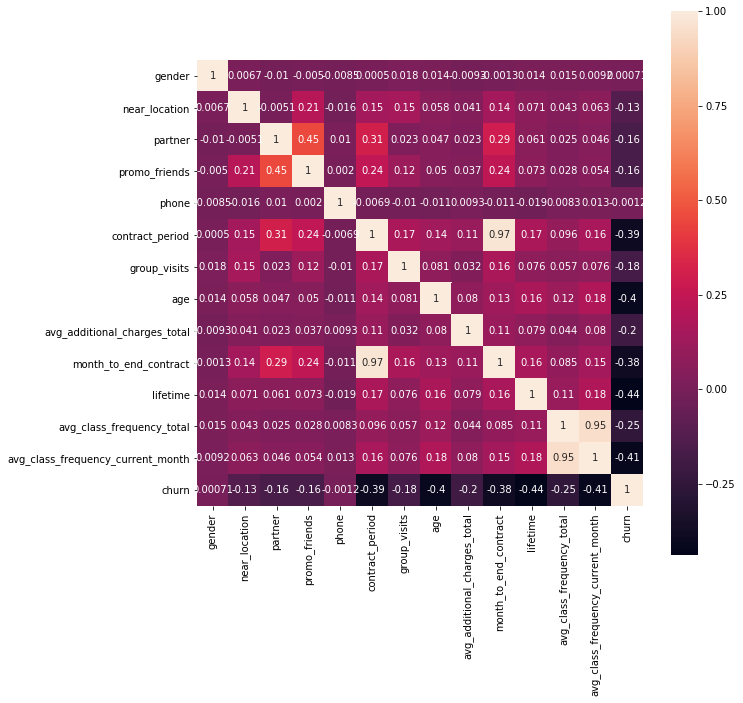

In [14]:
# создадим матрицу корреляции признаков
cm = raw_data.corr()

# выведем матрицу корреляции в виде графика heatmap
plt.figure(figsize = (10, 10)) 
sns.heatmap(cm, annot = True, square = True)
plt.show()

На матрице видим категории с высокой степенью корреляии:

- средняя посещаемость групповых занятий общая и средняя посещаемость групповых занятий в последний месяц;
- срок контракта и количество месяцев до конца контракта.

## 3. Модели прогнозирования оттока клиентов

В данной части спрогнозируем отток клиентов в следующем месяце. Так как целевая переменная является бинарной величиной (отток случается либо не случается), то будем использовать модели с алгоритмами для бинарной классификации - логистическую регрессию и случайный лес.


По этим метрикам сделаем вывод, какая из моделей сделала лучший прогноз.

<a id='section_3.1'></a>
### 3.1 Подготовка данных и функций

В первую очередь разделим имеющиеся данные на обучающую и валидационную выборки в пропорции 80 / 20 и стандартизируем их. 

In [15]:
# выделим матрицу с признаками и целевую переменную
X = raw_data.drop('churn', axis = 1)
y = raw_data['churn']

In [16]:
# разобьем данные на обучающую (80%) и валидационную(20%) выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 0)

In [17]:
# стандартизируем данные
scaler = StandardScaler()

scaler.fit(X_train)

X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

В дальнейшем для оценки моделей нам потребуется сравнить их основные метрики. Напишем функцию, которая будет выводить данные метрики для каждой модели.

In [18]:
# напишем функцию, которая будет выводить метрики для моделей
def print_all_metrics(y_true, y_pred, y_proba, title):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

<a id='section_3.2'></a>
### 3.2 Логистическая регрессия

Обучим модель с помощью алгоритма логистической регрессии на обучающей выборке и сделаем прогнозы целевой переменной на основании признаком валидационной выборки. 

In [19]:
# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression()

# обучим модель методом логистической регрессии
lr_model.fit(X_train_st, y_train)

# сделаем прогноз с помощью обученной модели
lr_y_pred = lr_model.predict(X_test_st)

# получим вероятности принадлежности к классам
lr_y_probas = lr_model.predict_proba(X_test_st)[:, 1]

Для сравнения попробуем кастомизировать модель, устанавливая порог вероятности, при значении ниже / выше которого целевая переменная будет относиться к тому или иному классу.

In [20]:
# устанавливаем порог
threshold = 0.4

# на основании вероятностей и соотношения классов рассчитаем прогноз
custom_predictions = [0 if i < threshold else 1 for i in lr_y_probas]

<a id='section_3.3'></a>
### 3.3 Случайный лес

Дополнительно обучим модель с использованием алгоритма случайный лес. Количество деревьев, на основании которых будем строить лес (n_estimators) мы настроили, предварительно протестировав различные варианты и сравнив метрики, получаемые в каждом случае.

In [21]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 330, random_state = 0)

# обучим модель методом случайного леса
rf_model.fit(X_train_st, y_train)

# сделаем прогноз с помощью обученной модели
rf_y_pred = rf_model.predict(X_test_st) 

# получим вероятности принадлежности классам
rf_y_probas = rf_model.predict_proba(X_test_st)[:, 1]

<a id='section_3.4'></a>
### 3.4 Сравнение метрик моделей

Сравним полученные прогнозы целевой переменной с фактическими показателями целевой переменной. 

На основании результатов полученных в ходе сравнения оценим такие метрики для каждой модели, как accuracy, precision и recall. 

In [22]:
# выведем значения метрик для модели логистической регрессии
print_all_metrics(y_test, lr_y_pred, lr_y_probas, 'Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy: 0.94
	Precision: 0.90
	Recall: 0.85


In [23]:
# выведем значения метрик для модели логистической регрессии с кастомным порогом
print_all_metrics(y_test, custom_predictions, custom_predictions, 
                  'Метрики для модели логистической регрессии (с кастомным порогом):')

Метрики для модели логистической регрессии (с кастомным порогом):
	Accuracy: 0.93
	Precision: 0.86
	Recall: 0.88


In [24]:
# выведем значения метрик для модели случайного леса
print_all_metrics(y_test, rf_y_pred, rf_y_probas, 'Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy: 0.93
	Precision: 0.89
	Recall: 0.84


Анализ результатов работы моделей показывает следующее:

1. Доля правильных ответов (accuracy) выше у 2 моделей логистической регрессии и составляет 94%, что является хорошим показателем. У модели случайного леса данный показатель ниже на 1%.

2. Модели более существенно отличаются по точности (precision) и полноте (recall).

3. Наиболее высокий показатель точности - 90% - показал алгоритм логистическая регрессия. Это означает, что среди тех клиентов, которых модель определила, как уходящих в отток в следующем месяце, 90% действительно прекратили посещать фитнес-центр.

4. Наиболее высокий показатель полноты - 88% - показала модель логистическая регрессия с кастомным порогом 0.4. Данный показатель означает, что из всех клиентов, которые в следующем месяце прекратили посещать фитнес-центр, мы смогли выявить 88%.

На основании вышеизложенного можно сделать следующий вывод о наиболее предпочтительной модели:

1) Если методы работы с клиентами, определенными как уходящие в отток в следующем месяце, будут затратными с точки зрения финансов и других ресурсов (например, скидки / бонусы / бесплатные посещения классов и пр.), то стоит остановиться на модели с более высоким показателем точности, то есть на логистической регрессии. Это будет означать, что мы реже будем тратить ресурсы впустую (на клиентов, которые в самом деле не планировали прекращать занятия).

2) В том случае, если привлечение новых клиентов для нас более затратно, чем удержание старых с помощью бонусов и прочих вышеобозначенных методов, то нам стоит выбрать модель с максимальным показателем полноты - то есть логистическую регрессию с кастомным порогом 0.4. В таком случае, мы охватим превентивными мерами большую долю клиентов, которые действительно планируют прекратить посещение центра.  

## 4. Кластеризация клиентов

<a id='section_4.1'></a>
### 4.1 Определение количества кластеров на основании дендрограммы

Для того, чтобы понять, какие группы наших клиентов более склонны к оттоку, сегментируем наших клиентов с помощью кластеризации и изучим характеристики каждой группы.

Для начала определем расстояния между всеми клиентами с помощью функции linkage и построим дендрограмму, на основании которой примем решение о количестве кластеров.

In [25]:
# стандартизируем матрицу признаков
X_st = scaler.fit_transform(X)

In [26]:
# построим матрицу расстояний
linked = linkage(X_st, method = 'ward') 

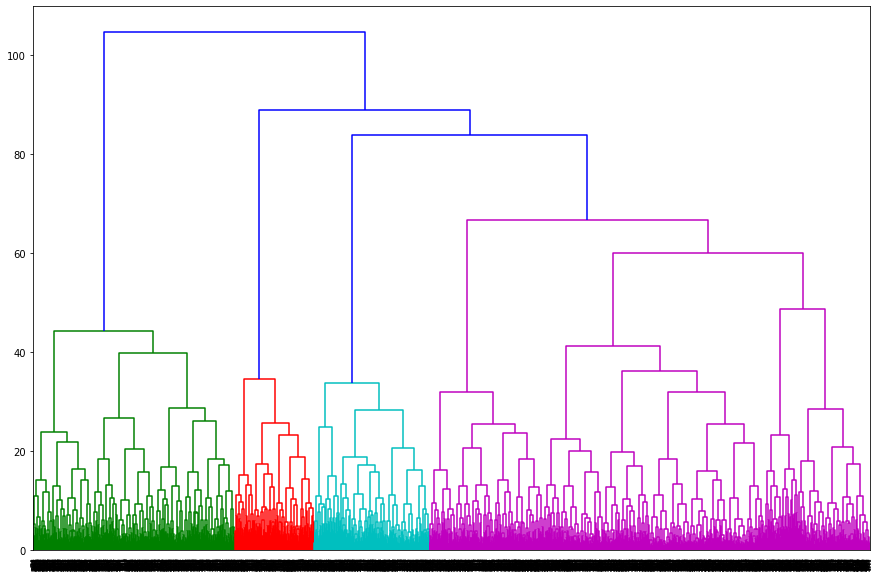

In [27]:
# нарисуем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

На основании полученной дендрограммы мы решили остановиться на 5 кластерах. Выделим их с помощью алгоритма K-Means.

<a id='section_4.2'></a>
### 4.2 Кластеризация и анализ признаков каждого кластера

In [28]:
# задаём число кластеров, равное 5
km = KMeans(n_clusters = 5, random_state = 0) 

# применяем алгоритм к данным и формируем вектор кластеров
labels = km.fit_predict(X_st)  

# сохраним данные с информацией о кластерах в новый датафрейм
data_clusters = raw_data

# добавляем в новый датафрейм столбец с номером кластера
data_clusters['cluster_km'] = labels

In [29]:
# смотрим средние значения признаков для каждого кластера
data_clusters.groupby('cluster_km').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.502473,0.959446,0.783383,0.574679,1.000000,10.884273,0.543027,29.980218,160.706969,9.950544,4.738872,1.983305,1.976225,0.027695
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.560335,0.976105,0.356033,0.229391,0.998805,2.665472,0.473118,30.127838,161.724258,2.455197,4.896057,2.851531,2.849473,0.068100


На основании средних значений признака `churn` можно сделать вывод, что наименее склонны к оттоку кластеры 0 (отток около 3%) и 4 (отток около 7%).

Наиболее высокий процент оттока у кластеров 3 (более 51%) и 2 (более 44% оттока).

Далее изучим характеристики всех групп - в особенности вышеобозначенных - чтобы определить признаки, наиболее характерные для групп с высоким оттоком и групп с низким оттоком. 

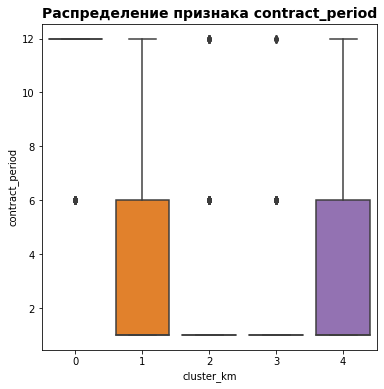

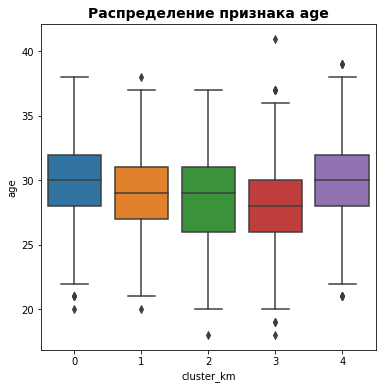

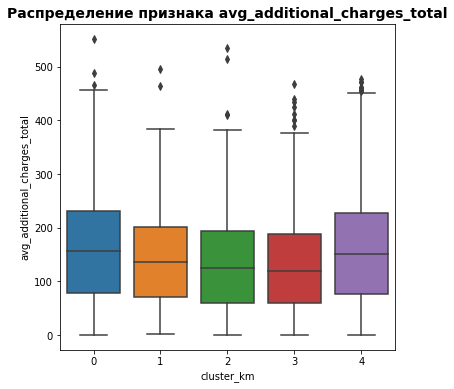

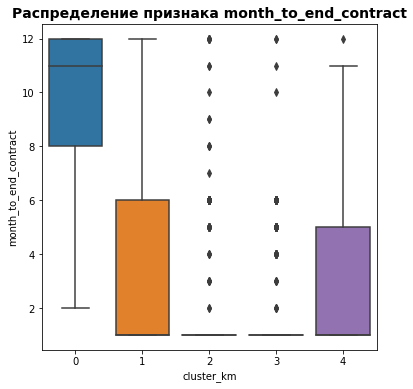

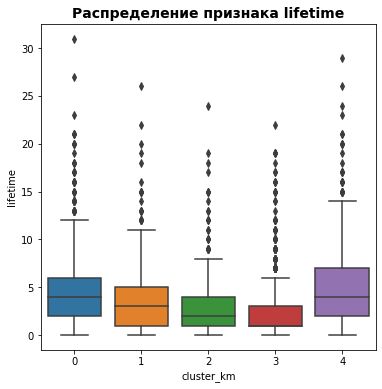

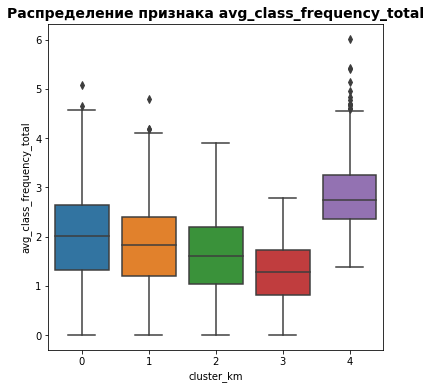

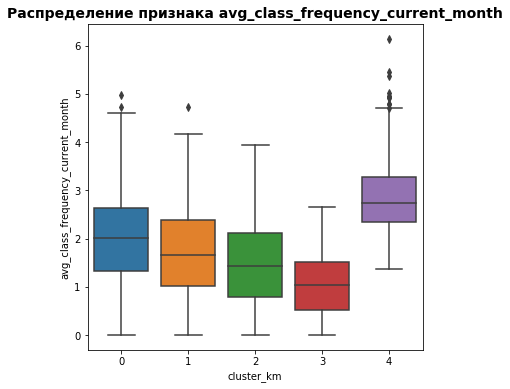

In [30]:
# визуализируем распределение признака для количественных признаков
compare_quantative_characteristics(data_clusters, quantative_vars, 'cluster_km')

Проведя анализ количественных признаков каждого кластера мы сделали следующие наблюдения:

1) срок абонемента - существенно отличается у кластеров, склонных и не склонных к оттоку, значительно выше у кластеров с низким оттоком.

2) медиана возраста клиентов в кластерах, не склонных к оттоку, составляет 30 лет. В кластерах, склонных к оттоку, она на 1-2 года ниже.

3) медиана затрат на дополнительные услуги в кластерах 0 и 4 (не склонных к оттоку) примерно на 15% выше чем в кластерах 3 и 2 (склонных к оттоку). Возможно, это связано с в целом более высоким уровнем доходов клиентов из данных групп.

4) количество месяцев до окончания абонемента - существенно больше у клиентов из кластеров, не склонных к оттоку.

5) количество месяцев с первого посещения - также больше у клиентов из кластеров 0 и 4, чем у клиентов из кластеров 3 и 2.

6) среднее количество посещенных групповых занятий - клиенты из кластеров, не склонных к оттоку, в целом и в течение последнего месяца чаще посещали групповые занятия. 

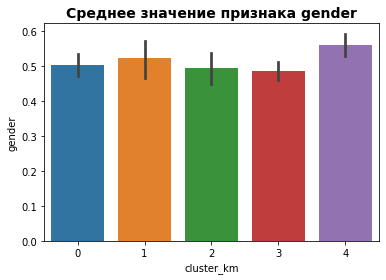

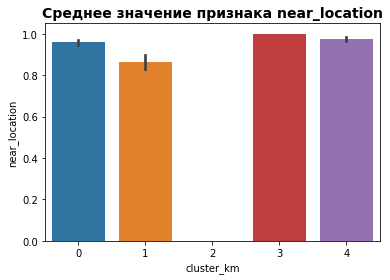

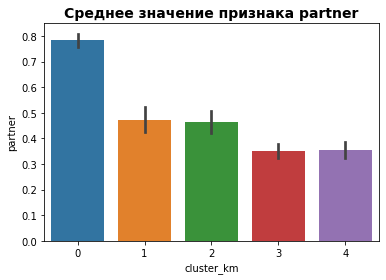

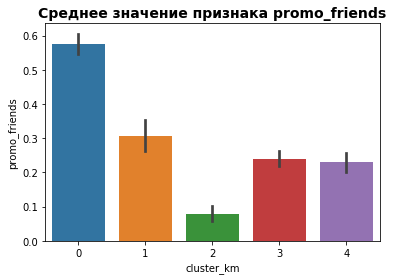

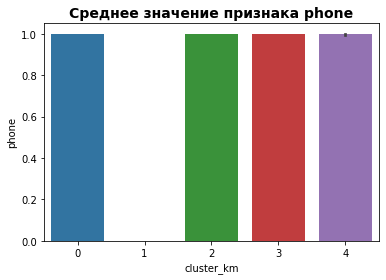

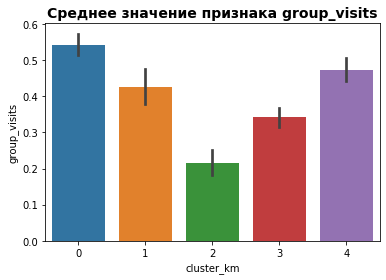

In [31]:
# сравним средние значения категориальных признаков
compare_categorial_characteristics(data_clusters, categorial_vars, 'cluster_km')

Сравнив категориальные признаки мы заметили следующее:

1) клиенты пола, который обозначен как 1, чуть менее склонны к оттоку - их больше в группах с низким оттоком.

2) большая доля клиентов лояльных кластеров посещает групповые занятия.

Категориальные характеристики, не влияющие на отток:

1) местоположение дома / офиса вблизи от фитнес-центра не является признаком, указывающим на склонность клиента к оттоку, так как в группе 3 - в которой находится максимальное количество клиентов, прекративших посещать фитнес-центры, количество клиентов, которые либо живут, либо работают вблизи от фитнес-центра, больше чем в группе 4, которая не склонна к оттоку.

2) нельзя однозначно утверждать, что наличие партнерской программы, влияет на снижение оттока - так, например в группе 3 (с оттоком 51%) количество клиентов, работающих у партнеров, существенно выше чем в обеих группе с низким процентом оттока. Аналогичное можно отметить про участие в программе "Приведи друга" - количество клиентов, участвовавших в программе, гораздо выше в одной из групп с высоким оттоком, чем в группах с низким оттоком.

3) наличие номера телефона в базе данных не влияет на снижение оттока.

## 5. Выводы и рекомендации

<a id='section_5.1'></a> 
### 5.1 Выводы

#### Выводы относительно наиболее эффективной модели прогнозирования оттока

Анализ результатов работы моделей показывает следующее:

1. Доля правильных ответов (accuracy) выше у 2 моделей логистической регрессии и составляет 94%, что является хорошим показателем. У модели случайного леса данный показатель ниже на 1%.

2. Модели более существенно отличаются по точности (precision) и полноте (recall).

3. Наиболее высокий показатель точности - 90% - показал алгоритм логистическая регрессия. Это означает, что среди тех клиентов, которых модель определила, как уходящих в отток в следующем месяце, 90% действительно прекратили посещать фитнес-центр.

4. Наиболее высокий показатель полноты - 88% - показала модель логистическая регрессия с кастомным порогом 0.4. Данный показатель означает, что из всех клиентов, которые в следующем месяце прекратили посещать фитнес-центр, мы смогли выявить 88%.

На основании вышеизложенного можно сделать следующий вывод о наиболее предпочтительной модели:

1) Если методы работы с клиентами, определенными как уходящие в отток в следующем месяце, будут затратными с точки зрения финансов и других ресурсов (например, скидки / бонусы / бесплатные посещения классов и пр.), то стоит остановиться на модели с более высоким показателем точности, то есть на логистической регрессии. Это будет означать, что мы реже будем тратить ресурсы впустую (на клиентов, которые в самом деле не планировали прекращать занятия).

2) В том случае, если привлечение новых клиентов для нас более затратно, чем удержание старых с помощью бонусов и прочих вышеобозначенных методов, то нам стоит выбрать модель с максимальным показателем полноты - то есть логистическую регрессию с кастомным порогом 0.4. В таком случае, мы охватим превентивными мерами большую долю клиентов, которые действительно планируют прекратить посещение центра.  

#### Выводы о признаках, более всего влияющих на отток

Проведя анализ количественных и категориальных признаков каждого кластера мы сделали следующие выводы о том, какие характеристики более всего влияют на отток:

1) срок абонемента - значительно выше у кластеров с низким оттоком.

2) количество месяцев до окончания абонемента - клиенты, у которых абонемент не подошел к концу менее склонны к оттоку.

3) количество посещенных групповых занятий - клиенты из кластеров, не склонных к оттоку, в целом и в течение последнего месяца чаще посещали групповые занятия. 

#### Портрет лояльного клиента

Клиент 
- пола категории 1, 
- в возрасте от 28 до 30 лет, 
- со стабильным доходом, приобретающий дополнительные платные услуги в клубе, 
- имеющий абонемент со сроком 6-12 месяцев, 
- посещающий групповые занятия.

<a id='section_5.2'></a>
### 5.2 Рекомендации

С учетом вышеобозначенного можно дать следующие рекомендации:

1. Использовать наиболее подходящую модель для прогнозирования оттока в следующем месяце.

2. Проводить работу с клиентами, которых модель определила, как уходящих в отток - предлагать бонусы / скидки / пробные бесплатные посещения групповых занятий.

3. Таргетировать рекламу на клиентов, подходящих под описание лояльного клиента.